In [104]:
from torch import nn
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from core.data.dataset import SlidingWindowDataset
from torch.utils.data import DataLoader

In [105]:
class MLPTradingBaseline(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 4)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [106]:
df = pd.read_csv('../../data/raw/BTCUSDT.csv', sep='|', header=None, usecols=[0, 1, 2, 3, 4, 5], 
                 names=['timestemp', 'open', 'high', 'low', 'close', 'volume'], nrows=1000)
df['timestemp'] = pd.to_datetime(df['timestemp'], unit='s')

tensor_data = torch.tensor(df.set_index('timestemp').sort_index().values, dtype=torch.float32)

In [107]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [108]:
look_back = 10
look_ahead = 4
features_count = 5
batch_size = 32

dataset = SlidingWindowDataset(tensor_data, look_back=look_back, look_ahead=look_ahead, 
                                 input_indices=range(features_count), target_indices=[3])

sequences = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [109]:
model = MLPTradingBaseline(look_back*features_count).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-10)

epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for x, y in sequences:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x).unsqueeze(dim=-1)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f'epoch: {epoch}, loss: {epoch_loss/len(dataset)}')
      

epoch: 0, loss: 552373.7598784195
epoch: 1, loss: 455384.12158054713
epoch: 2, loss: 351962.36778115504
epoch: 3, loss: 236288.60739614995
epoch: 4, loss: 128720.24442755825
epoch: 5, loss: 54674.44953140831
epoch: 6, loss: 18992.825671225935
epoch: 7, loss: 6126.819576367781
epoch: 8, loss: 2100.26524506079
epoch: 9, loss: 815.1080630224164
epoch: 10, loss: 353.69041435141213
epoch: 11, loss: 166.1212364745599
epoch: 12, loss: 83.30102341177495
epoch: 13, loss: 45.10722893712006
epoch: 14, loss: 27.125312781986132
epoch: 15, loss: 18.576973896741624
epoch: 16, loss: 14.493499601261714
epoch: 17, loss: 12.537322379656235
epoch: 18, loss: 11.598504879071237
epoch: 19, loss: 11.147506041367366


In [110]:
y_close_pred = []
model.eval()
with torch.no_grad():
    for x, y in sequences:
        x = x.to(device)
        y_pred = model(x)
        y_close_pred.append(y_pred[:, 0].cpu())
    y_close_pred = torch.cat(y_close_pred, dim=0)

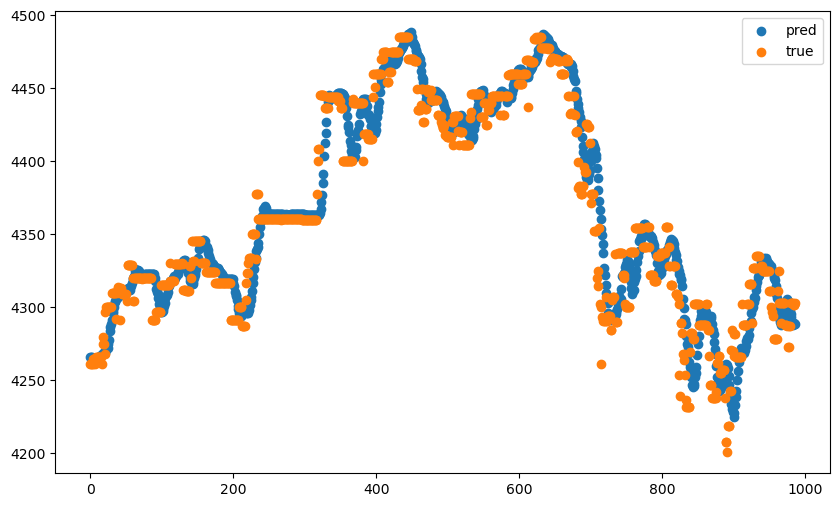

In [111]:
plt.figure(figsize=(10, 6))
plt.tight_layout()
plt.scatter(x = range(len(y_close_pred)), y = y_close_pred, label='pred')
plt.scatter(x = range(len(y_close_pred)), y = df['close'].values[-len(y_close_pred):], label='true')
# plt.xlim(700, 1000); 
plt.legend();